## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

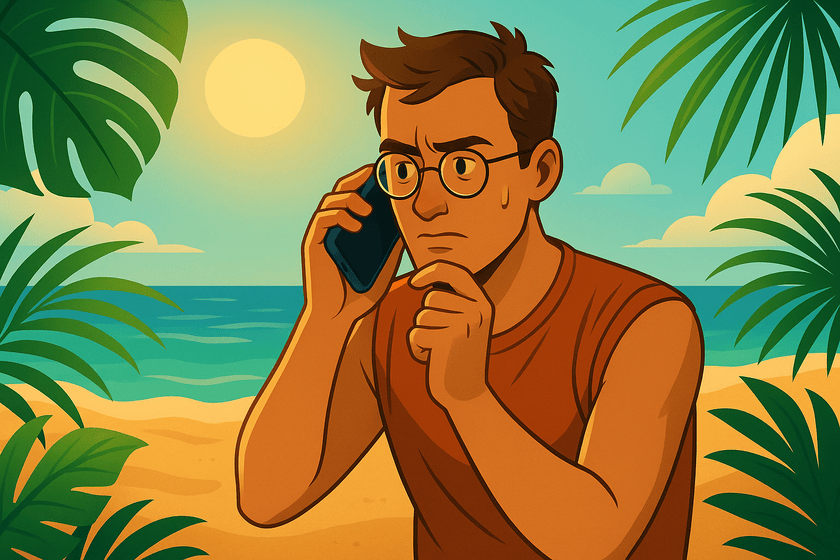

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

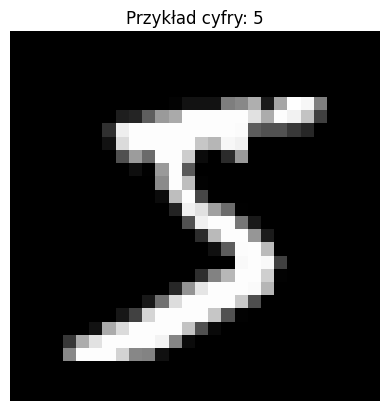

In [49]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

# Obserwacje z poprzednich zadań

# Przydatne rzeczy
* W zadaniu o titanicu kluczowe było zidentyfikowanie, które cechy miały najwiekszy wpływ na wynik. W tym zadaniu mamy obrazy więc będę analizować na co model zwraca uwage(np. krawędzie), analogicznie do identyfikowania ważnych cech.

* Pamiętając o kolumnie Cabin z poprzedniego zadania trzeba pamiętać o potencjalnie brakujących bądź błędnych danych.

* Wybranie odpowiednich metryk do ustalenia jak radzi sobie model.

# Mniej przydatne rzeczy

* Inżynieria cech dla zadania o titanicu nie będą miały zastosowania dla danych obrazowych.

# Wybór i uzasadnienie metryk oceny

W zadaniach klasyfikacji, dokładność (accuracy) jest często pierwszym punktem odniesienia, ale warto spojrzeć na inne metryki, aby lepiej zrozumieć wydajność modelu, zwłaszcza w kontekście potencjalnych błędów.

Dla zadania klasyfikacji ręcznie pisanych cyfr (problem wieloklasowy), kluczowe metryki to:

1.  **Dokładność (Accuracy)**:
    *  Stosunek liczby poprawnie sklasyfikowanych przykładów do całkowitej liczby przykładów.
    *   Podstawowa i intuicyjna metryka, która daje ogólne pojęcie o tym, jak często model poprawnie przewiduje cyfrę.

2.  **Precyzja (Precision)**:
    *   Jest to stosunek prawdziwie pozytywnych przewidywań (True Positives) do sumy prawdziwie pozytywnych i fałszywie pozytywnych przewidywań (False Positives). Mówi nam, jak wiele przykładów sklasyfikowanych jako należące do danej klasy faktycznie do niej należy.

3.  **Pełność (Recall)**:
    *  Jest to stosunek prawdziwie pozytywnych przewidywań (True Positives) do sumy prawdziwie pozytywnych i fałszywie negatywnych przewidywań (False Negatives). Mówi nam, jak wiele przykładów faktycznie należących do danej klasy zostało poprawnie zidentyfikowanych przez model.

4.  **Wynik F1 (F1-Score)**:
    *   Jest to średnia harmoniczna precyzji i pełności.

5.  **Macierz pomyłek (Confusion Matrix)**:
    *  Tabela, która pokazuje liczbę poprawnych i niepoprawnych przewidywań dla każdej klasy. Wiersze reprezentują rzeczywiste klasy, a kolumny przewidywane klasy.
    *   Macierz pomyłek jest niezwykle przydatnym narzędziem do wizualnej analizy, które cyfry model najczęściej ze sobą myli. Pozwala zidentyfikować konkretne pary cyfr, które są trudne do rozróżnienia dla modelu.


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Utworzenie Baseline'u

In [51]:
# Definiowanie transformacji danych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Ładowanie pełnego zbioru danych treningowych
full_train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Podział zbioru treningowego na treningowy i walidacyjny
train_size = int(0.8 * len(full_train_dataset)) # 80% na trening
val_size = len(full_train_dataset) - train_size # Reszta na walidację
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Utworzenie DataLoaderów dla treningu, walidacji i testu
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False) # Shuffle=False dla walidacji
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False) # Shuffle=False dla testu


# Definicja prostej sieci neuronowej
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128) # Warstwa wejściowa: 28x28 pikseli
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10) # Warstwa wyjściowa: 10 klas (cyfry 0-9)

    def forward(self, x):
        x = x.view(-1, 28 * 28) # Spłaszczenie obrazu
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Inicjalizacja modelu, funkcji straty i optymalizatora
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [52]:
# Trening modelu
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0

        print(f"\nEwaluacja na zbiorze walidacyjnym po epoce {epoch+1}/{epochs}")
        val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(model, val_loader)
        print("----------------------------------------------------")

In [68]:

# Ewaluacja modelu
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predicted, average='weighted')
    print(f'Precision : {precision:.2f}')
    print(f'Recall : {recall:.2f}')
    print(f'F1-Score : {f1_score:.2f}')

    cm = confusion_matrix(all_labels, all_predicted)
    print(f'Confusion-Matrix:\n {cm}')
    return accuracy, precision, recall, f1_score, cm


In [54]:
print("\nTrening modelu NN\n")
train_model(model, train_loader, val_loader, criterion, optimizer)



Trening modelu NN

Epoch [1/3], Step [100/750], Loss: 0.6384
Epoch [1/3], Step [200/750], Loss: 0.3260
Epoch [1/3], Step [300/750], Loss: 0.2667
Epoch [1/3], Step [400/750], Loss: 0.2304
Epoch [1/3], Step [500/750], Loss: 0.2153
Epoch [1/3], Step [600/750], Loss: 0.1692
Epoch [1/3], Step [700/750], Loss: 0.1759

Ewaluacja na zbiorze walidacyjnym po epoce 1/3
Dokładność modelu na danych testowych: 95.14%
Precision : 0.95
Recall : 0.95
F1-Score : 0.95
----------------------------------------------------
Epoch [2/3], Step [100/750], Loss: 0.1349
Epoch [2/3], Step [200/750], Loss: 0.1277
Epoch [2/3], Step [300/750], Loss: 0.1240
Epoch [2/3], Step [400/750], Loss: 0.1271
Epoch [2/3], Step [500/750], Loss: 0.1173
Epoch [2/3], Step [600/750], Loss: 0.1197
Epoch [2/3], Step [700/750], Loss: 0.1091

Ewaluacja na zbiorze walidacyjnym po epoce 2/3
Dokładność modelu na danych testowych: 96.28%
Precision : 0.96
Recall : 0.96
F1-Score : 0.96
----------------------------------------------------
Epoc

In [69]:
baseline_accuracy, baseline_precision, baseline_recall, baseline_f1, baseline_cm = evaluate_model(model, test_loader)

Accuracy: 97.05%
Precision : 0.97
Recall : 0.97
F1-Score : 0.97
Confusion-Matrix:
 [[ 959    0    1    2    1    3    7    1    3    3]
 [   0 1113    3    3    0    1    6    0    9    0]
 [   3    2  993    5    4    1    6    7   11    0]
 [   0    0    3  994    0    4    0    3    3    3]
 [   0    0    3    1  952    0    4    1    2   19]
 [   2    0    0   14    2  861    5    1    4    3]
 [   4    3    1    1    5    7  932    0    5    0]
 [   0    5    8   11    2    0    0  978    0   24]
 [   3    0    2   12    5    3    3    4  937    5]
 [   0    3    0    5    5    4    1    3    2  986]]


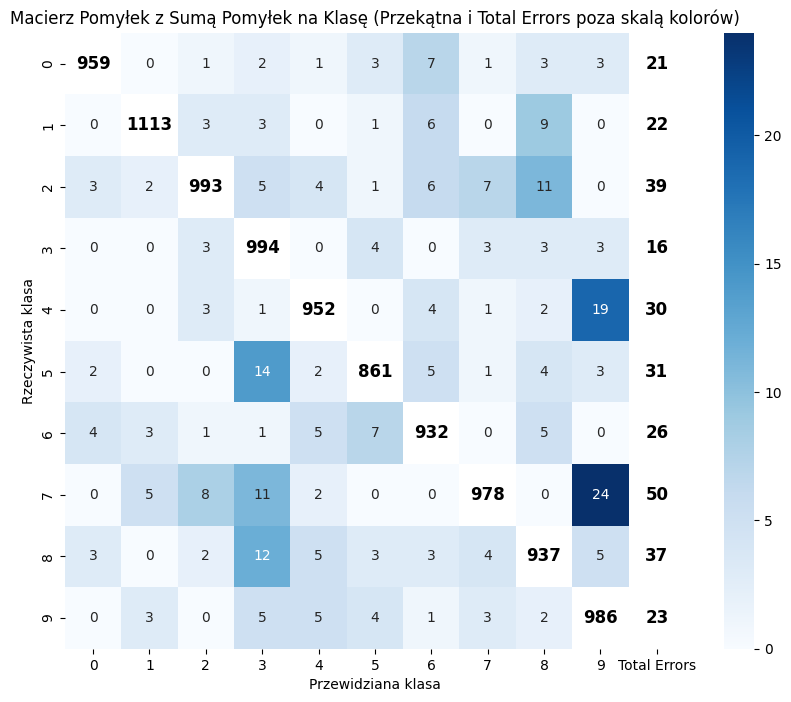

In [56]:
def plot_confusion_matrix_with_errors(cm, classes):
    """
    Wizualizuje macierz pomyłek jako heatmapę, ignorując przekątną i kolumnę Total Errors
    w skali kolorów, i dodaje kolumnę z sumą pomyłek.

    Args:
        cm (np.ndarray): Macierz pomyłek.
        classes (list): Lista nazw klas (np. [0, 1, ..., 9]).
    """
    # Obliczanie sumy pomyłek dla każdej klasy
    misclassifications_per_digit = []
    for i in range(cm.shape[0]):
        total_misclassified = np.sum(cm[i, :]) - cm[i, i]
        misclassifications_per_digit.append(total_misclassified)

    # Tworzenie rozszerzonej macierzy
    cm_extended = np.hstack((cm, np.array(misclassifications_per_digit).reshape(-1, 1)))
    col_labels = classes + ['Total Errors']


    # Utworzenie maski dla elementów na przekątnej i kolumny Total Errors
    mask = np.zeros_like(cm_extended, dtype=bool)
    for i in range(cm.shape[0]):
      mask[i, i] = True
    mask[:, -1] = True


    plt.figure(figsize=(10, 8))
    cm_off_diagonal = cm - np.diag(np.diag(cm))
    max_off_diagonal = np.max(cm_off_diagonal)

    sns.heatmap(cm_extended, annot=True, fmt='d', cmap='Blues',
                xticklabels=col_labels, yticklabels=classes,
                mask=mask,
                vmin=0, vmax=max_off_diagonal)

    # Rysowanie elementow na przekątnej osobno bez wplywu na skale kolorow
    for i in range(cm.shape[0]):
        plt.text(i + 0.5, i + 0.5, str(cm[i, i]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='black',
                 size='large',
                 weight='bold')



    # Rysowanie wartości z kolumny Total Errors osobno
    for i in range(cm_extended.shape[0]):
        plt.text(cm_extended.shape[1] - 0.5, i + 0.5, str(cm_extended[i, -1]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='black',
                 size='large',
                 weight='bold')


    plt.title('Macierz Pomyłek z Sumą Pomyłek na Klasę (Przekątna i Total Errors poza skalą kolorów)')
    plt.xlabel('Przewidziana klasa')
    plt.ylabel('Rzeczywista klasa')
    plt.show()


classes = [str(i) for i in range(10)]
plot_confusion_matrix_with_errors(baseline_cm, classes)

Baseline osiągnął zaskakująco wysoki wynik, więc musi to oznaczać że zbiór danych jest na tyle prosty, że nawet taki model radzi sobie dobrze (albo coś przeoczyłem).


Analiza Macierzy Pomyłek ujawnia, które cyfry model myli najczęściej. Widać, że trudności sprawiają mu przede wszystkim cyfry, które są wizualnie podobne, takie jak:

*   **Cyfry 8 i 9**: Są często mylone ze sobą lub z innymi cyframi (np. 8 mylone z 1 i 2, 9 mylone z 4 i 7).
*   **Cyfry 7 i 9**: Mogą być mylone ze względu na podobieństwo kształtu.
*   **Cyfry 1 i 8**: Czasami mylone, prawdopodobnie ze względu na podobieństwo pionowych elementów.

Najwięcej pomyłek (błędnych klasyfikacji) zanotowano dla cyfr **7** (50 pomyłek) i **2** (39 pomyłek).

Wysoka dokładność baseline'u pokazuje, że model nauczył się podstawowych wzorców cyfr. Jednak błędy koncentrują się na przypadkach, gdzie subtelne różnice w piśmie odręcznym powodują pomyłki.

# Tworzenie i eksperymentowanie z modelem CNN

In [57]:
# Definicja prostej sieci konwolucyjnej (CNN)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Warstwa konwolucyjna 1: 1 wejście (obraz w skali szarości), 32 wyjścia (mapy cech)
        # Rozmiar jadra 3x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        # zmniejsza wymiarowość przestrzeni (2x2 okno)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Warstwa konwolucyjna 2: 32 wejścia (z poprzedniej warstwy), 64 wyjścia
        # Rozmiar jądra  3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = x.view(-1, 64 * 7 * 7)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

cnn_model = SimpleCNN()
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)




In [59]:
print("Trening modelu CNN:")
train_model(cnn_model, train_loader, val_loader, cnn_criterion, cnn_optimizer, epochs=5)

Trening modelu CNN:
Epoch [1/5], Step [100/750], Loss: 0.5169
Epoch [1/5], Step [200/750], Loss: 0.1494
Epoch [1/5], Step [300/750], Loss: 0.1164
Epoch [1/5], Step [400/750], Loss: 0.0943
Epoch [1/5], Step [500/750], Loss: 0.0762
Epoch [1/5], Step [600/750], Loss: 0.0652
Epoch [1/5], Step [700/750], Loss: 0.0802

Ewaluacja na zbiorze walidacyjnym po epoce 1/5
Dokładność modelu na danych testowych: 98.17%
Precision : 0.98
Recall : 0.98
F1-Score : 0.98
----------------------------------------------------
Epoch [2/5], Step [100/750], Loss: 0.0503
Epoch [2/5], Step [200/750], Loss: 0.0516
Epoch [2/5], Step [300/750], Loss: 0.0403
Epoch [2/5], Step [400/750], Loss: 0.0522
Epoch [2/5], Step [500/750], Loss: 0.0439
Epoch [2/5], Step [600/750], Loss: 0.0481
Epoch [2/5], Step [700/750], Loss: 0.0521

Ewaluacja na zbiorze walidacyjnym po epoce 2/5
Dokładność modelu na danych testowych: 98.45%
Precision : 0.98
Recall : 0.98
F1-Score : 0.98
----------------------------------------------------
Epoc

In [70]:
print("\nOcena modelu CNN na danych testowych:")
cnn_accuracy, cnn_precision, cnn_recall, cnn_f1, cnn_cm = evaluate_model(cnn_model, test_loader)



Ocena modelu CNN na danych testowych:
Accuracy: 99.10%
Precision : 0.99
Recall : 0.99
F1-Score : 0.99
Confusion-Matrix:
 [[ 975    0    0    1    0    0    0    0    3    1]
 [   0 1133    1    1    0    0    0    0    0    0]
 [   1    2 1025    0    0    0    0    3    1    0]
 [   0    0    2 1006    0    1    0    0    1    0]
 [   0    1    1    0  973    0    0    0    2    5]
 [   2    0    0    9    0  879    1    0    1    0]
 [   4    4    0    0    3    4  941    0    1    1]
 [   0    1    3    0    0    0    0 1022    1    1]
 [   2    0    1    0    0    0    0    0  970    1]
 [   0    0    0    3    2    7    0    5    6  986]]


In [61]:
print("\nPorównanie z modelem Baseline:")
print(f"Baseline Accuracy: {baseline_accuracy:.2f}%")
print(f"Baseline Accuracy: {baseline_precision:.2f}%")
print(f"Baseline Accuracy: {baseline_recall:.2f}%")
print(f"Baseline Accuracy: {baseline_f1:.2f}%")



Porównanie z modelem Baseline:
Baseline Accuracy: 97.05%
Baseline Accuracy: 0.97%
Baseline Accuracy: 0.97%
Baseline Accuracy: 0.97%


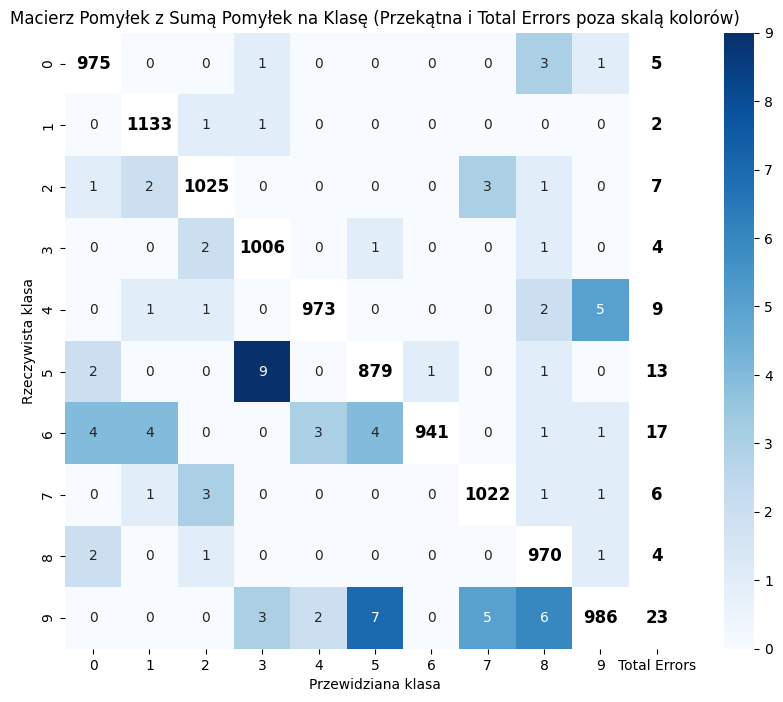

In [62]:
plot_confusion_matrix_with_errors(cnn_cm, classes)

# Wnioski z analizy modelu CNN

Model CNN osiągnął wyższą dokładność w porównaniu do baseline'owej prostej sieci neuronowej

Analiza Macierzy Pomyłek dla modelu CNN pokazuje znaczną poprawę w redukcji błędów w porównaniu do baseline'u. Liczba pomyłek dla większości cyfr jest znacznie niższa.

Patrząc na kolumnę "Total Errors" i elementy poza przekątną, widać, że model CNN nadal ma pewne trudności z rozróżnianiem niektórych cyfr, choć w znacznie mniejszym stopniu niż baseline:

*   **Cyfra 9**: Nadal generuje najwięcej pomyłek (23), często mylona z 7, 8, 5, 6.
*   **Cyfra 5**: Zanotowała 13 pomyłek, głównie mylona z 3.
*   **Cyfra 4**: Zanotowała 9 pomyłek, głównie mylona z 9.
*   **Cyfra 6**: Zanotowała 17 pomyłek, mylona głównie z 0, 1, 4, 5.

**Porównanie z Baseline'em:**

*   **Poprawa ogólnej dokładności**
*   **Znaczna redukcja pomyłek**: Macierz pomyłek CNN ma znacznie niższe wartości poza przekątną w porównaniu do baseline'u, co wskazuje na lepsze rozróżnianie cyfr.
*   **Trudniejsze przypadki**: Mimo poprawy, cyfry takie jak 9, 5 i 6 nadal stanowią największe wyzwanie dla modelu, podobnie jak w przypadku baseline'u, ale z mniejszą częstotliwością i z nieco innymi typami pomyłek.


### Wariant 1: CNN Głębsza (3 warstwy konwolucyjne)

In [71]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dodatkowa warstwa konwolucyjna
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Dodatkowy pooling

        # Obliczanie rozmiaru wejścia do warstw gęstych po 3 warstwach poolingu
        # Obraz 28x28 -> po pool1 (14x14) -> po pool2 (7x7) -> po pool3 (3x3 lub 4x4 w zależności od paddingu/stride)
        # Przy stride=2 i kernel=2, 28 -> 14 -> 7 -> 3
        # Rozmiar wejścia do fc1: liczba kanałów * ostateczny rozmiar obrazu * ostateczny rozmiar obrazu
        # Po pool3 mamy 128 kanałów i obraz 3x3 (lub 4x4, trzeba sprawdzić dokładnie)
        # Przyjmijmy 3x3 po 3 poolach 2x2 ze stride 2
        self.fc1 = nn.Linear(128 * 3 * 3, 128) # Dostosuj rozmiar wejścia
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Spłaszczenie
        x = x.view(-1, 128 * 3 * 3) # Dostosuj rozmiar

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

# Inicjalizacja, trening i ewaluacja
deeper_cnn_model = DeeperCNN()
deeper_cnn_criterion = nn.CrossEntropyLoss()
deeper_cnn_optimizer = optim.Adam(deeper_cnn_model.parameters(), lr=0.001)

# Użyj funkcji train_model i evaluate_model zdefiniowanych wcześniej
# deeper_cnn_accuracy, _, _, _, deeper_cnn_cm = evaluate_model(deeper_cnn_model, test_loader)
# print(f"Deeper CNN Accuracy: {deeper_cnn_accuracy:.2f}%")
# plot_confusion_matrix_with_errors(deeper_cnn_cm, classes)

In [72]:
print("Trening modelu Deeper CNN:")
train_model(deeper_cnn_model, train_loader, val_loader, deeper_cnn_criterion, deeper_cnn_optimizer, epochs=5)

Trening modelu Deeper CNN:
Epoch [1/5], Step [100/750], Loss: 0.6447
Epoch [1/5], Step [200/750], Loss: 0.1512
Epoch [1/5], Step [300/750], Loss: 0.1049
Epoch [1/5], Step [400/750], Loss: 0.0901
Epoch [1/5], Step [500/750], Loss: 0.0853
Epoch [1/5], Step [600/750], Loss: 0.0674
Epoch [1/5], Step [700/750], Loss: 0.0581

Ewaluacja na zbiorze walidacyjnym po epoce 1/5
Accuracy: 98.58%
Precision : 0.99
Recall : 0.99
F1-Score : 0.99
Confusion-Matrix:
 [[1131    0    1    2    0    1    7    0    7    3]
 [   1 1311    1    3    0    0    1    0    3    0]
 [   1    2 1188    5    0    0    1    4   11    1]
 [   0    1    2 1227    0    2    0    1    5    3]
 [   0    2    0    0 1151    0    2    0    2    4]
 [   0    0    0    9    1 1014    4    1    6    0]
 [   1    0    1    0    3    1 1207    0    5    0]
 [   1    2    5    3    5    0    0 1225    3    5]
 [   0    4    1    2    1    3    1    1 1219    3]
 [   2    1    0    4    5    1    0    4    2 1157]]
-----------------

In [73]:
print("\nOcena modelu CNN na danych testowych:")
deep_accuracy, deep_precision, deep_recall, deep_f1, deep_cm = evaluate_model(deeper_cnn_model, test_loader)


Ocena modelu CNN na danych testowych:
Accuracy: 99.30%
Precision : 0.99
Recall : 0.99
F1-Score : 0.99
Confusion-Matrix:
 [[ 971    0    1    0    0    1    5    2    0    0]
 [   0 1129    1    2    0    0    3    0    0    0]
 [   0    0 1028    0    0    0    1    3    0    0]
 [   0    0    0 1009    0    0    0    1    0    0]
 [   0    0    0    0  975    0    0    2    0    5]
 [   1    0    0    7    0  879    3    0    0    2]
 [   0    1    0    0    2    1  954    0    0    0]
 [   0    2    1    2    0    0    0 1020    2    1]
 [   1    0    1    1    1    0    2    0  967    1]
 [   0    0    0    1    4    1    0    4    1  998]]


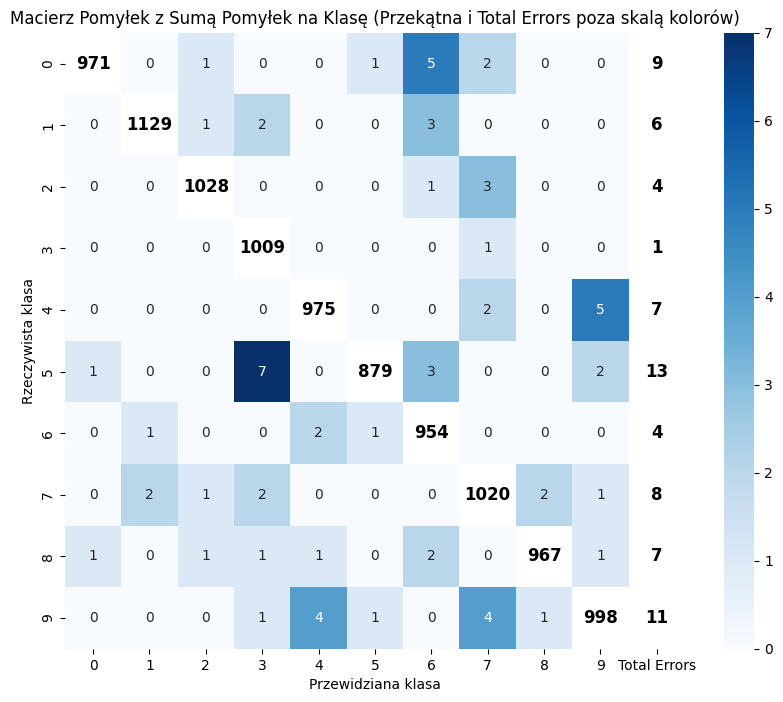

In [74]:
plot_confusion_matrix_with_errors(deep_cm, classes)

# Wnioski z analizy modelu CNN Głębsza

Model CNN Głębsza (z 3 warstwami konwolucyjnymi) osiągnął dokładność **~99.30%** na zbiorze testowym. Jest to nieznacznie wyższa dokładność niż w przypadku prostej sieci CNN (~99.10%). Sugeruje to, że dodanie kolejnej warstwy konwolucyjnej mogło pomóc w ekstrakcji jeszcze bardziej złożonych i abstrakcyjnych cech z obrazów, co przełożyło się na niewielką poprawę klasyfikacji.

Analiza Macierzy Pomyłek dla modelu CNN Głębszej pokazuje dalszą redukcję liczby pomyłek w porównaniu do prostego modelu CNN.

Patrząc na kolumnę "Total Errors" i elementy poza przekątną, widać, że liczba błędów jest jeszcze niższa. Najwięcej pomyłek zanotowano dla:

*   **Cyfra 9**: 11 pomyłek (spadek z 23 w Simple CNN). Nadal mylona z 4, 5, 6, 7, 8.
*   **Cyfra 5**: 13 pomyłek (wzrost z 11 w Simple CNN). Głównie mylona z 3 i 7.

**Porównanie z Simple CNN:**

*   **Nieznaczna poprawa dokładności**: Głębszy model uzyskał nieco lepsze wyniki ogólne.
*   **Ogólna redukcja pomyłek**: Mimo niewielkich wahań dla poszczególnych cyfr, łączna liczba pomyłek jest niższa.
*   **Zmiana wzorców pomyłek**: Choć 9 nadal jest cyfrą generującą najwięcej błędów, typowe pomyłki mogą się nieco różnić w porównaniu do Simple CNN.

Dodanie warstwy konwolucyjnej przyniosło marginalną poprawę dokładności. Pewni to oznacza, że dalsze pogłębianie sieci na tym zbiorze danych może nie przynieść znaczących korzyści, lub wymaga dalszego dostrojenia innych hiperparametrów.

### Wariant 2: CNN Szersza (2 warstwy konwolucyjne, więcej kanałów)

In [75]:
class WiderCNN(nn.Module):
    def __init__(self):
        super(WiderCNN, self).__init__()
        # Więcej kanałów w pierwszej warstwie
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Więcej kanalow w drugiej warstwie
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Obraz 28x28 po pool1 (14x14)po pool2 (7x7)
        # Mamy 128 kanałow
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = x.view(-1, 128 * 7 * 7)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

wider_cnn_model = WiderCNN()
wider_cnn_criterion = nn.CrossEntropyLoss()
wider_cnn_optimizer = optim.Adam(wider_cnn_model.parameters(), lr=0.001)



In [76]:
print("\nTrening modelu Wider CNN:")
train_model(wider_cnn_model, train_loader, val_loader, wider_cnn_criterion, wider_cnn_optimizer, epochs=5)


Trening modelu Wider CNN:
Epoch [1/5], Step [100/750], Loss: 0.4013
Epoch [1/5], Step [200/750], Loss: 0.1262
Epoch [1/5], Step [300/750], Loss: 0.0882
Epoch [1/5], Step [400/750], Loss: 0.0666
Epoch [1/5], Step [500/750], Loss: 0.0658
Epoch [1/5], Step [600/750], Loss: 0.0685
Epoch [1/5], Step [700/750], Loss: 0.0647

Ewaluacja na zbiorze walidacyjnym po epoce 1/5
Accuracy: 98.65%
Precision : 0.99
Recall : 0.99
F1-Score : 0.99
Confusion-Matrix:
 [[1149    0    0    0    0    0    0    0    2    1]
 [   1 1313    2    0    1    0    0    2    1    0]
 [   1    0 1198    2    0    0    1    7    3    1]
 [   0    1    4 1212    0   13    0    4    3    4]
 [   0    2    3    0 1148    0    3    0    1    4]
 [   1    0    2    1    0 1023    3    0    2    3]
 [   7    1    1    0    3    6 1197    0    3    0]
 [   0    1    4    0    5    2    0 1235    1    1]
 [   1    5    2    1    2    5    3    0 1204   12]
 [   2    1    0    0    5    2    0    4    3 1159]]
-----------------

In [77]:
wider_accuracy, wider_precision, wider_recall, wider_f1, wider_cm = evaluate_model(wider_cnn_model, test_loader)

Accuracy: 98.93%
Precision : 0.99
Recall : 0.99
F1-Score : 0.99
Confusion-Matrix:
 [[ 973    0    0    0    0    0    4    1    2    0]
 [   0 1123    1    2    0    0    5    3    1    0]
 [   0    0 1028    0    0    0    0    3    1    0]
 [   0    0    1 1008    0    1    0    0    0    0]
 [   0    0    1    0  960    0    6    2    3   10]
 [   0    0    0    6    0  884    1    0    1    0]
 [   1    2    0    0    1    5  948    0    1    0]
 [   0    0    8    0    0    0    0 1019    1    0]
 [   2    0    2    2    0    0    0    2  964    2]
 [   1    0    1    0    3    7    0    8    3  986]]


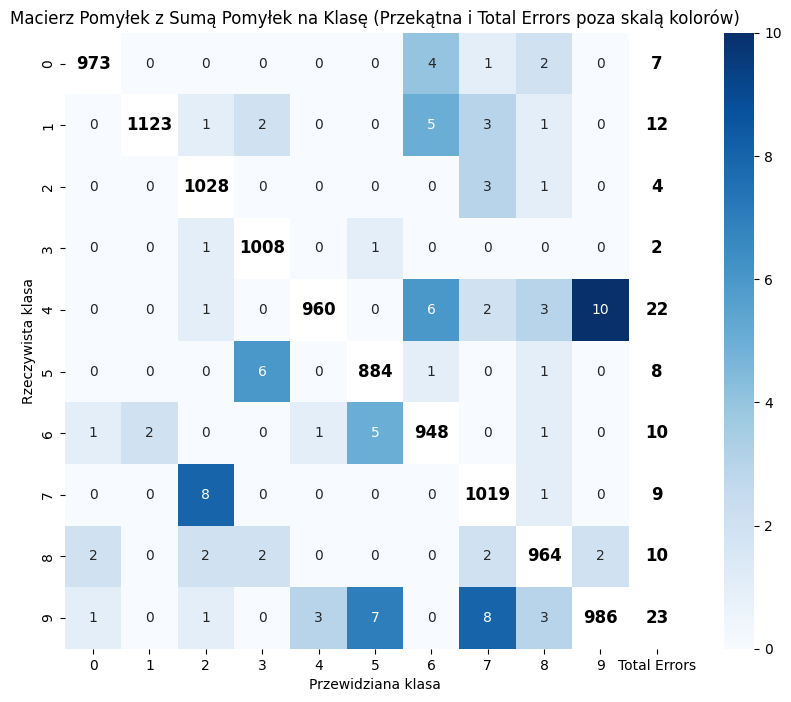

In [78]:
plot_confusion_matrix_with_errors(wider_cm, classes)

# Wnioski z analizy modelu CNN Szersza

Szerszy model CNn (z większą liczbą kanałów, ale taką samą głębokością jak Simple CNN) osiągnął dokładność **98.93%** na zbiorze testowym. Jest to nieznacznie niższa dokładność w porównaniu do Simple CNN 99.10% i Deeper CNN 99.30%. Sugeruje to, że zwiększenie liczby kanałów bez zwiększania głębokości nie przyniosło poprawy, a wręcz delikatnie pogorszyło wyniki w tym przypadku.

Analiza Macierzy Pomyłek dla modelu CNN Szerszej pokazuje, że mimo ogólnie wysokiej dokładności, wzorce błędów mogą się nieco różnić od poprzednich modeli.


*   **Cyfra 9**: 23 pomyłki (podobna liczba jak w Simple CNN, więcej niż w Deeper CNN). Mylona głównie z 4, 7, 8, 3, 5, 6.
*   **Cyfra 4**: 22 pomyłki (znacznie więcej niż w Simple CNN i Deeper CNN). Mylona głównie z 9, 6, 8.
*   **Cyfra 1**: 12 pomyłek (więcej niż w poprzednich modelach).


**Porównanie z Simple CNN i Deeper CNN:**

*   **Nieznacznie niższa dokładność**: Szerszy model uzyskał wyniki gorsze niż oba poprzednie warianty CNN.
*   **Zmiana wzorców pomyłek**: Zwiększenie szerokości sieci zmieniło to, które cyfry są najczęściej mylone i z jakimi innymi cyframi. Szczególnie widoczny jest wzrost pomyłek dla cyfry 4 i 1 w porównaniu do Simple CNN i Deeper CNN.

W tym konkretnym przypadku na zbiorze MNIST, zwiększenie szerokości sieci bez zwiększania głębokości okazało się mniej korzystne niż zwiększenie samej głębokości. Może to sugerować, że dla tego zbioru danych kluczowe jest uczenie się hierarchicznych cech na kolejnych poziomach abstrakcji (co umożliwia większa głębokość), a niekoniecznie większa liczba różnych cech na tym samym poziomie (co umożliwia większa szerokość).

### Wariant 3: CNN z BatchNorm i Dropout

In [79]:
class CNNAugmented(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNAugmented, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Warstwa 1: Conv -> BatchNorm -> ReLU -> Pool
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Warstwa 2: Conv -> BatchNorm -> ReLU -> Pool
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = x.view(-1, 64 * 7 * 7)

        # Warstwy w pełni połączone: Linear -> Dropout -> Linear
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

cnn_augmented_model = CNNAugmented(dropout_rate=0.5) # tu eksperymentowac
cnn_augmented_criterion = nn.CrossEntropyLoss()
cnn_augmented_optimizer = optim.Adam(cnn_augmented_model.parameters(), lr=0.001)


In [80]:
print("\nTrening modelu CNN z BatchNorm i Dropout:")
train_model(cnn_augmented_model, train_loader, val_loader, cnn_augmented_criterion, cnn_augmented_optimizer, epochs=5)


Trening modelu CNN z BatchNorm i Dropout:
Epoch [1/5], Step [100/750], Loss: 0.5572
Epoch [1/5], Step [200/750], Loss: 0.1668
Epoch [1/5], Step [300/750], Loss: 0.1589
Epoch [1/5], Step [400/750], Loss: 0.1449
Epoch [1/5], Step [500/750], Loss: 0.1123
Epoch [1/5], Step [600/750], Loss: 0.1281
Epoch [1/5], Step [700/750], Loss: 0.1124

Ewaluacja na zbiorze walidacyjnym po epoce 1/5
Accuracy: 97.88%
Precision : 0.98
Recall : 0.98
F1-Score : 0.98
Confusion-Matrix:
 [[1135    0    0    0    0    0    2    0   14    1]
 [   1 1301   10    1    0    0    0    2    5    0]
 [   1    1 1188    2    0    0    0    3   18    0]
 [   2    0   15 1188    0    9    0    1   22    4]
 [   0    3    1    0 1144    0    2    0    3    8]
 [   0    0    1    1    1 1017    4    0   10    1]
 [   1    2    4    0   12    3 1180    0   16    0]
 [   0    2   16    1    3    1    0 1220    2    4]
 [   0    2    4    0    1    0    0    0 1224    4]
 [   2    1    0    2    5    5    0    4    9 1148]]
-

In [81]:
print("\nOcena modelu CNN z BatchNorm i Dropout na danych testowych:")
cnn_augmented_accuracy, cnn_augmented_precision, cnn_augmented_recall, cnn_augmented_f1, cnn_augmented_cm = evaluate_model(cnn_augmented_model, test_loader)



Ocena modelu CNN z BatchNorm i Dropout na danych testowych:
Accuracy: 98.94%
Precision : 0.99
Recall : 0.99
F1-Score : 0.99
Confusion-Matrix:
 [[ 976    0    0    0    0    0    1    1    1    1]
 [   0 1133    1    0    0    0    0    1    0    0]
 [   3    2 1018    2    0    0    0    4    2    1]
 [   0    0    1 1003    0    5    0    0    1    0]
 [   0    1    0    0  968    0    0    1    4    8]
 [   1    0    0    3    0  886    1    1    0    0]
 [   2    2    0    0    5    8  941    0    0    0]
 [   0    1    6    0    0    0    0 1019    2    0]
 [   4    0    2    1    2    1    0    0  963    1]
 [   1    0    0    2    2    7    0    3    7  987]]


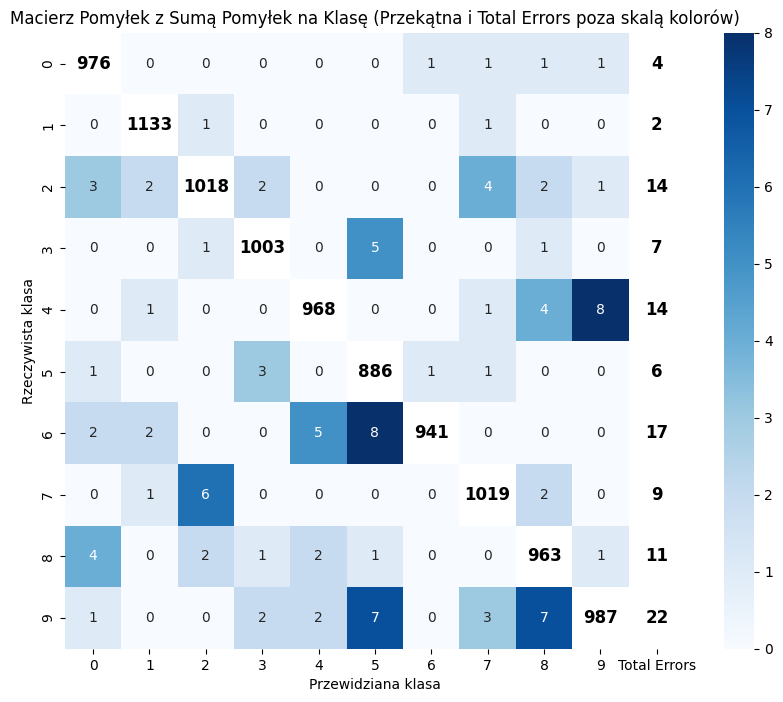

In [82]:
plot_confusion_matrix_with_errors(cnn_augmented_cm, classes)

# Wnioski z analizy modelu CNN z BatchNorm i Dropout

Model CNN z dodanymi warstwami Normalizacji Batcha BatchNorm i Wypadania Dropout osiągnął dokładność **98.94%** na zbiorze testowym. Jest to wynik bardzo zbliżony do Simple CNN 99.10% i nieco niższy od Deeper CNN 99.30%, ale nieco wyższy od Wider CNN 98.93%.

Analiza Macierzy Pomyłek dla tego modelu pokazuje:

Patrząc na kolumnę "Total Errors" i elementy poza przekątną, najwięcej pomyłek zanotowano dla:

*   **Cyfra 9**: 22 pomyłki (podobna liczba jak w Simple i Wider CNN, więcej niż w Deeper CNN).
*   **Cyfra 2**: 14 pomyłek (więcej niż w poprzednich modelach CNN).
*   **Cyfra 4**: 14 pomyłek (więcej niż w Simple i Deeper CNN).
*   **Cyfra 8**: 11 pomyłek (więcej niż w Simple CNN).
*   **Cyfra 6**: 17 pomyłek (podobna liczba jak w Simple CNN, więcej niż w Deeper i Wider CNN).

**Porównanie z poprzednimi modelami CNN:**

*   **Podobna ogólna dokładność**: Dodanie BatchNorm i Dropout w tej konfiguracji nie przyniosło znaczącej poprawy dokładności na zbiorze testowym w porównaniu do Simple CNN, a nawet uzyskało nieco niższy wynik niż Deeper CNN. Może to sugerować, że dla tego konkretnego zbioru danych i prostej architektury, overfitting nie był dużym problemem, lub że wartości dropout_rate wymagały lepszego dostrojenia.
*   **Zmiana wzorców pomyłek**: Wprowadzenie BatchNorm i Dropout zmieniło to, które cyfry są najczęściej mylone i z jakimi innymi cyframi. Widać pewne zwiększenie pomyłek dla cyfr 2, 4 i 8 w porównaniu do Simple CNN.


dodanie BatchNorm i Dropout nie przyniosło znaczącej poprawy na zbiorze testowym. Możliwe, że dalsze eksperymenty z wartością dropout_rate zmniejszenie jej lub zastosowanie tych technik w głębszej lub szerszej sieci przyniosłoby lepsze rezultaty.

# Wnioski Końcowe i Potencjalne Rozwiązania

## Podsumowanie Eksperymentów:

Przeprowadziliśmy serię eksperymentów z różnymi architekturami sieci neuronowych w celu klasyfikacji ręcznie pisanych cyfr ze zbioru MNIST:

1.  **Baseline (Prosta Sieć Neuronowa)**:
    *   Osiągnął dokładność około **97.05%**.
    *   Macierz pomyłek pokazała, że model miał trudności z rozróżnianiem wizualnie podobnych cyfr, zwłaszcza 7, 8 i 9.

2.  **Simple CNN (2 warstwy konwolucyjne)**:
    *   Osiągnął znacznie lepszą dokładność około **99.10%**.
    *   Znacząco zredukował liczbę pomyłek w porównaniu do baseline'u, potwierdzając skuteczność warstw konwolucyjnych w zadaniach obrazowych. Cyfra 9 nadal była najczęściej mylona.

3.  **Deeper CNN (3 warstwy konwolucyjne)**:
    *   Osiągnął najwyższą dokładność spośród testowanych modeli, około **99.30%**.
    *   Dalsza redukcja pomyłek w porównaniu do Simple CNN, choć poprawa była marginalna. Cyfra 9 nadal generowała najwięcej błędów, a cyfra 5 stała się kolejnym wyzwaniem.

4.  **Wider CNN (2 warstwy konwolucyjne, więcej kanałów)**:
    *   Osiągnął nieco niższą dokładność niż Simple i Deeper CNN, około **98.93%**.
    *   Zmiana szerokości sieci wpłynęła na wzorce pomyłek, zwiększając błędy dla cyfr 4 i 1 w porównaniu do poprzednich modeli CNN.

5.  **CNN z BatchNorm i Dropout (na bazie Simple CNN)**:
    *   Osiągnął dokładność około **98.94%**, podobną do Wider CNN i nieco niższą od Simple i Deeper CNN.
    *   Techniki regularyzacji nie przyniosły znaczącej poprawy na tym prostym zbiorze, co sugeruje, że overfitting nie był głównym problemem dla tych architektur. Zmieniły jednak wzorce pomyłek.

**Najlepiej działający model:**

Spośród przetestowanych wariantów, **model Deeper CNN** uzyskał najwyższą dokładność na zbiorze testowym. Dodanie kolejnej warstwy konwolucyjnej okazało się najskuteczniejszą modyfikacją architektury w tych eksperymentach.
